In [1]:
from functions import *
from import_data import *

from astropy.constants import R_sun, L_sun, sigma_sb
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [2]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()
df_BJ = BailerJones()

Calculate observed luminosity

In [3]:
df_L = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": [None] * len(df_hmxb['id']),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST_short": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id']),
                              "logL_true/L_sun": [None] * len(df_hmxb['id']),
                              "Teff": [None] * len(df_hmxb['id'])})

In [4]:
for i in range(df_hmxb.shape[0]):
    # Object id
    id = df_hmxb.loc[i, 'id']

    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "ST"]

    # Effective temperature based on spectral type
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Expected (B-V)0 of object based on spectral type
    BV0 = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='(B-V)0')

    # Observed (B-V) of object based on simbad filters
    BVobs = df_hmxb.loc[i, '(B-V)obs']

    # Bolometric correction (BC)
    BCv = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCv')

    # Distance
    distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

    # Calculate extinction
    Av = 3.2 * (BVobs - BV0)

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(distance) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + BCv

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff

In [5]:
df_L

,id,L_true,L_expected,ST_short,ST,logL_true/L_sun,Teff
0,2S0114+650,153646.995447,None,None,None,5.186524,27748.0
1,SMC X-1,321188.471,None,None,None,5.50676,30101.0
2,LMC X-4,140455.907034,None,None,None,5.14754,33179.0
3,Vela X-1,583066.293478,None,None,None,5.765718,28653.0
4,Cen X-3,7555336.675468,None,None,None,6.878254,31368.0
5,GX301-2,4761113.581809,None,None,None,6.677709,26843.0
6,4U1538-52,205579.884484,None,None,None,5.312981,29196.0
7,4U1700-37,495668.335316,None,None,None,5.695191,36801.0
8,4U1907+09,815429.784813,None,None,None,5.911387,32274.0
9,LMC X-1,288097.8443,None,None,None,5.45954,33179.0


Calculate observed radius

In [6]:
# Make radius dataframe
df_R = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "R_true": [None] * len(df_hmxb['id']),
                              "R_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a']
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']

    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST_short"].reset_index(drop=True).at[0]

    # Put R in luminosity dataframe
    df_R.loc[df_R["id"] == id, "R_true"] = Rob
    df_R.loc[df_R["id"] == id, "ST"] = df_hmxb.loc[df_hmxb["id"] == id, "ST"]


In [7]:
df_R

,id,R_true,R_expected,ST
0,2S0114+650,None,None,None
1,SMC X-1,16.254598,None,O9.7Ia+
2,LMC X-4,7.975631,None,O8III
3,Vela X-1,33.847001,None,B0.5Ia
4,Cen X-3,12.094002,None,O9III
5,GX301-2,None,None,None
6,4U1538-52,11.249967,None,B0.2Ia
7,4U1700-37,23.198571,None,O6Iafcp
8,4U1907+09,None,None,None
9,LMC X-1,None,None,None


Calculate the expected radius from the Teff and the observed luminosity

In [8]:
for i in range(df_hmxb.shape[0]):
    # Spectral type
    spectral_type = df_hmxb.loc[i, 'ST']
    ST_short = df_hmxb.loc[i, 'ST_short']

    # id
    id = df_hmxb.loc[i, 'id']

    # True luminosity
    L = df_L.loc[df_L["id"] == id, "L_true"].reset_index(drop=True).at[0]


    # Effective temperature from model
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Calculate the radius
    R = np.sqrt((L_sun.value / R_sun.value**2) * (L / (4 * np.pi * sigma_sb.value * Teff**4)))

    # Save luminosity in dataframe
    df_R.loc[i, "R_expected"] = R
    df_R.loc[i, "ST"] = df_hmxb.loc[i, "ST"]

In [9]:
# Calculate ratio
df_R["R_expected/R_true"] = df_R["R_expected"] / df_R["R_true"]

In [10]:
df_R = df_R.dropna()

Mass

In [11]:
df_M = pd.read_excel("tables/M_expBONNSAI.xlsx")
df_M = pd.merge(df_M, df_falenga, on='id')[["id", "M_exp", "M_opt"]]
df_M["M_opt/M_exp"] = df_M["M_opt"] / df_M["M_exp"]

In [12]:
df_MR = pd.merge(df_M, df_R, on='id')

In [13]:
df_MR

,id,M_exp,M_opt,M_opt/M_exp,R_true,R_expected,ST,R_expected/R_true
0,SMC X-1,28.8,18,0.625000,16.254598,20.838732,O9.7Ia+,1.282021
1,Vela X-1,38.4,26,0.677083,33.847001,30.986458,B0.5Ia,0.915486
2,LMC X-4,21.8,18,0.825688,7.975631,11.342181,O8III,1.422105
3,4U1700-37,35.8,46,1.284916,23.198571,17.319267,O6Iafcp,0.746566
4,4U1538-52,22.4,16,0.714286,11.249967,17.721348,B0.2Ia,1.575236
5,Cen X-3,126.4,24,0.189873,12.094002,93.069293,O9III,7.695492


Plot

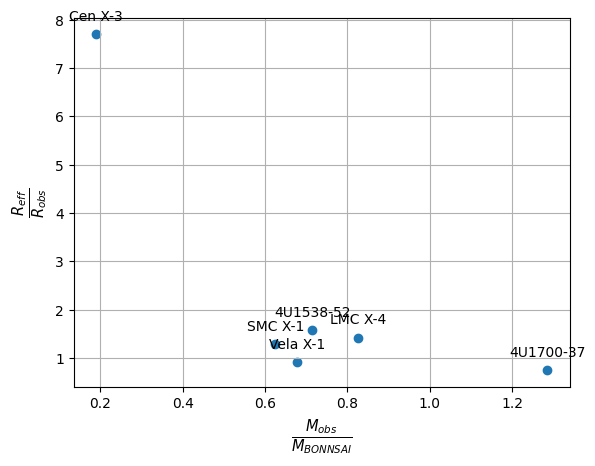

In [18]:
plt.scatter(df_MR["M_opt/M_exp"], df_MR["R_expected/R_true"])
# Add labels to each point
for i, label in enumerate(df_MR["id"].tolist()):
    plt.annotate(label, (df_MR["M_opt/M_exp"].tolist()[i], df_MR["R_expected/R_true"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.ylim(1,2)
# plt.xlim(0,1)
plt.grid(True)
plt.xlabel(r"$\frac{M_{obs}}{M_{BONNSAI}}$", fontsize=15)
plt.ylabel(r"$\frac{R_{eff}}{R_{obs}}$", fontsize=15)
plt.show()

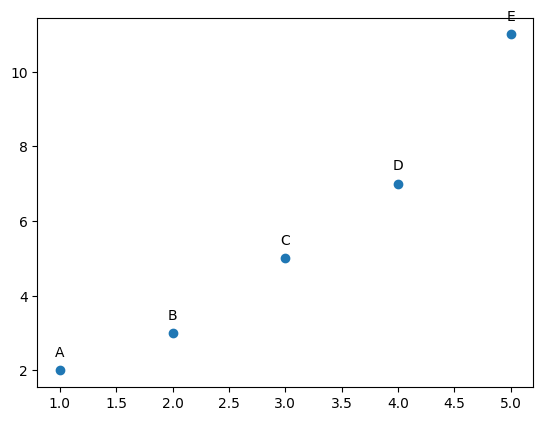

In [ ]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]
labels = ['A', 'B', 'C', 'D', 'E']

# Create a scatter plot
plt.scatter(x, y)



# Show the plot
plt.show()